# Fine tune YOLOv8 on pothole dataset
1. Make sure the download the dataset from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/pothole-detection).
2. In this case, we are tuning the model on Colab, therefore, data is placed on Google Drive (in `ML/pothole_det/pothole`) by mounting the entie drive to the notebook. Please adapt this part, if you are not using Colab/Drive.

In [1]:
!pip -q install ultralytics lxml tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00


In [2]:
import os, glob, random, shutil, xml.etree.ElementTree as ET
from pathlib import Path
from google.colab import drive
from tqdm import tqdm
from ultralytics import YOLO

# Mount the Google Drive
drive.mount('/content/drive')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


In [3]:
# Adjust following path as per your data dirctory.
DATA_DIR = Path("/content/drive/MyDrive/ML/pothole_det/pothole")
IMG_DIR = DATA_DIR/"images"
ANN_DIR = DATA_DIR/"annotations"

WORK = Path("/content/pothole_yolo")
(IM_TRAIN := WORK/"images/train").mkdir(parents=True, exist_ok=True)
(IM_VAL   := WORK/"images/val").mkdir(parents=True, exist_ok=True)
(LB_TRAIN := WORK/"labels/train").mkdir(parents=True, exist_ok=True)
(LB_VAL   := WORK/"labels/val").mkdir(parents=True, exist_ok=True)

CLASS_NAMES = ["pothole"]

# Convert VOC XML to YOLO format
def voc2yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    fname = root.find("filename").text
    W = int(root.find("size/width").text)
    H = int(root.find("size/height").text)

    img_path = IMG_DIR/fname
    if not img_path.exists():  # fallback by stem
        matches = list(IMG_DIR.glob(Path(fname).stem + ".*"))
        if not matches:
            return None, []
        img_path = matches[0]

    rows = []
    for obj in root.findall("object"):
        bnd = obj.find("bndbox")
        xmin, ymin, xmax, ymax = [int(bnd.find(x).text) for x in ["xmin","ymin","xmax","ymax"]]
        cx = (xmin + xmax) / (2*W)
        cy = (ymin + ymax) / (2*H)
        w  = (xmax - xmin) / W
        h  = (ymax - ymin) / H
        rows.append(f"0 {cx} {cy} {w} {h}")  # class id 0 = pothole
    return img_path, rows

xmls = sorted(glob.glob(str(ANN_DIR/"*.xml")))
pairs = []
for xp in tqdm(xmls):
    img, rows = voc2yolo(xp)
    if img and rows:
        pairs.append((img, rows))

print(f"Found {len(pairs)} samples")

# Train/val split
random.seed(0)
random.shuffle(pairs)
split = int(0.8*len(pairs))
train, val = pairs[:split], pairs[split:]

def save(split, pairs):
    im_dir = IM_TRAIN if split=="train" else IM_VAL
    lb_dir = LB_TRAIN if split=="train" else LB_VAL
    for img_path, rows in pairs:
        shutil.copy2(img_path, im_dir/img_path.name)
        with open(lb_dir/(img_path.stem+".txt"), "w") as f:
            f.write("\n".join(rows))

save("train", train)
save("val", val)

yaml_path = Path("/content/pothole.yaml")
yaml_path.write_text(f"""
path: {WORK}
train: images/train
val: images/val
names:
  0: pothole
""")

# Train YOLO
model = YOLO("yolov8n.pt")  # small model for mobile
model.train(data=str(yaml_path), epochs=5, imgsz=640, batch=16)

# Export TFLite
tflite_fp16 = model.export(format="tflite", half=True)
print("Exported:", tflite_fp16)

100%|██████████| 665/665 [00:26<00:00, 25.01it/s] 


Found 665 samples
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/pothole.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

Export the model to TFLite format

In [4]:
from pathlib import Path
import shutil
from glob import glob

# Export to TFLite
tflite_fp16 = model.export(format="tflite", half=True)
print("TFLite FP16 path:", tflite_fp16)

# Save artifacts to Drive
OUT_DIR = Path("/content/drive/MyDrive/ML/pothole_det/fine_tuned_model")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) copy the TFLite
tflite_fp16_path = Path(tflite_fp16)
shutil.copyfile(str(tflite_fp16_path), str(OUT_DIR / tflite_fp16_path.name))

# 2) copy best.pt (if you want the PyTorch weights too)
best_pt_candidates = glob("/content/runs/detect/*/weights/best.pt")
if best_pt_candidates:
    shutil.copyfile(best_pt_candidates[-1], str(OUT_DIR / "best.pt"))

# 3) copy data.yaml (optional, handy for reference)
shutil.copyfile("/content/pothole.yaml", str(OUT_DIR / "pothole.yaml"))

print("Saved to:", OUT_DIR.resolve())

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)

TensorFlow SavedModel: starting export with tensorflow 2.19.0...

ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success ✅ 1.3s, saved as '/content/runs/detect/train/weights/best.onnx' (11.8 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.3...
Saved artifact at '/content/runs/detect/train/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 5, 8400), dtype=tf.float32, name=None)
Captures:
  137824823569936: TensorSpec(shape=(4

## Sample Inference

Testing on: /content/pothole_yolo/images/val/potholes174.png
Input details: [{'name': 'images', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([  1, 640, 640,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'Identity', 'index': 538, 'shape': array([   1,    5, 8400], dtype=int32), 'shape_signature': array([   1,    5, 8400], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


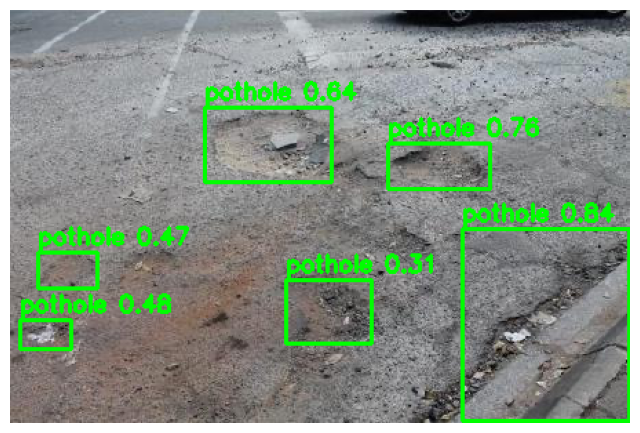

Detections: 6


In [5]:
import os, math, glob
import numpy as np
import cv2
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

# Paths
TFLITE_MODEL = "/content/drive/MyDrive/ML/pothole_det/fine_tuned_model/best_float16.tflite"
DATA_DIR = Path("/content/drive/MyDrive/pothol")
WORK = Path("/content/pothole_yolo")

# Pick a sample image
def pick_image():
    for pattern in [
        str(WORK/"images/val/*.jpg"), str(WORK/"images/val/*.png"),
        str(WORK/"images/train/*.jpg"), str(WORK/"images/train/*.png"),
        str(DATA_DIR/"images/*.jpg"), str(DATA_DIR/"images/*.png"),
    ]:
        files = glob.glob(pattern)
        if files:
            return files[1]
    raise FileNotFoundError("No sample image found in val/train/DATA_DIR images.")

img_path = pick_image()
print("Testing on:", img_path)

# Letterbox (Ultralytics-style)
def letterbox(im, new_shape=(640,640), color=(114,114,114)):
    shape = im.shape[:2]  # H, W
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    im_resized = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    dw /= 2; dh /= 2
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im_padded = cv2.copyMakeBorder(im_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im_padded, r, (left, top)

# NMS to merge/filter multipe Bbox
def iou_xyxy(a, b):
    # a,b = [x1,y1,x2,y2]
    xx1 = max(a[0], b[0]); yy1 = max(a[1], b[1])
    xx2 = min(a[2], b[2]); yy2 = min(a[3], b[3])
    w = max(0, xx2-xx1); h = max(0, yy2-yy1)
    inter = w*h
    areaA = (a[2]-a[0])*(a[3]-a[1])
    areaB = (b[2]-b[0])*(b[3]-b[1])
    union = areaA + areaB - inter
    return inter/union if union>0 else 0.0

def nms(dets, iou_thr=0.45):
    # dets: list of (x1,y1,x2,y2,score,cls)
    dets = sorted(dets, key=lambda x: x[4], reverse=True)
    keep = []
    while dets:
        best = dets.pop(0)
        keep.append(best)
        dets = [d for d in dets if iou_xyxy(best[:4], d[:4]) < iou_thr]
    return keep

# Load image and TFLite model
orig = cv2.imread(img_path)
orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
H0, W0 = orig_rgb.shape[:2]

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()
in_details = interpreter.get_input_details()
out_details = interpreter.get_output_details()

print("Input details:", in_details)
print("Output details:", out_details)

# Input shape
_, in_h, in_w, in_c = in_details[0]["shape"]

# Prepare input (letterbox to model size)
img_lb, r, (padw, padh) = letterbox(orig_rgb, (in_h, in_w))
inp = img_lb

# dtype handling
inp_dtype = in_details[0]["dtype"]
if inp_dtype == np.float32:
    inp = (inp.astype(np.float32) / 255.0)
elif inp_dtype == np.uint8:
    inp = inp.astype(np.uint8)
else:
    # fallback
    inp = inp.astype(inp_dtype)

inp = np.expand_dims(inp, 0)

# Run
interpreter.set_tensor(in_details[0]['index'], inp)
interpreter.invoke()

raw = interpreter.get_tensor(out_details[0]['index'])  # e.g. [1, 5, 8400] or [1, 6, 8400] or [1, 84/85, 8400]
out = raw[0]
# Make it (N, C)
if out.shape[0] < out.shape[1]:
    out = out.T  # (8400, C)
else:
    out = out.transpose(1, 0)  # just in case; we want anchors in dim 0

# Decode
C = out.shape[1]
detections = []
conf_thr = 0.25

for i in range(out.shape[0]):
    # Common layouts:
    # C==5: [cx, cy, w, h, conf]          (single-class)
    # C==6: [cx, cy, w, h, conf, cls]     (single-class with class id)
    # C>=6: [cx, cy, w, h, conf, p0, p1..](multi-class probs; score = conf * max(prob))
    cx, cy, bw, bh = out[i, 0], out[i, 1], out[i, 2], out[i, 3]
    if C == 5:
        conf = out[i, 4]
        cls = 0
    elif C == 6:
        conf = out[i, 4]
        cls = int(round(out[i, 5]))
    else:
        obj = out[i, 4]
        probs = out[i, 5:]
        cls = int(np.argmax(probs))
        conf = float(obj * probs[cls])

    if conf < conf_thr:
        continue

    # xywh (normalized on letterboxed image) -> xyxy in original image
    x1 = (cx - bw/2) * in_w
    y1 = (cy - bh/2) * in_h
    x2 = (cx + bw/2) * in_w
    y2 = (cy + bh/2) * in_h

    # remove padding and scale back to original size
    x1 = (x1 - padw) / r
    y1 = (y1 - padh) / r
    x2 = (x2 - padw) / r
    y2 = (y2 - padh) / r

    # clip
    x1 = int(max(0, min(W0-1, x1)))
    y1 = int(max(0, min(H0-1, y1)))
    x2 = int(max(0, min(W0-1, x2)))
    y2 = int(max(0, min(H0-1, y2)))

    if x2 <= x1 or y2 <= y1:
        continue
    detections.append((x1, y1, x2, y2, conf, cls))

# NMS
detections = nms(detections, iou_thr=0.45)

# Visualize
vis = orig_rgb.copy()
for (x1,y1,x2,y2,conf,cls) in detections:
    cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(vis, f"pothole {conf:.2f}", (x1, max(0,y1-6)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,255,0), 2)

plt.figure(figsize=(8,8))
plt.imshow(vis)
plt.axis("off")
plt.show()

print(f"Detections: {len(detections)}")
